# Handling the data

In [1]:
import sys
sys.path.insert(0, '/yunity/arusty/PF-GAP')

#Import libraries, MDS from SKlearn, and all the custom files
import pandas as pd
import matplotlib.pyplot as plt
from Pipeline.functions import *

#Functions
from QGAP.qgap import QGAP
from Redcomets.Redcomets import REDCOMETS
# from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket
# from RDST.rdst import RDST_GAP

In [2]:
static_data = pd.read_csv("/yunity/arusty/PF-GAP/data/sp500_fundamentals_combined.csv")
time_series = pd.read_csv("/yunity/arusty/PF-GAP/data/sp500_daily_returns_since_2022.csv")
stock_data = pd.read_csv("/yunity/arusty/PF-GAP/data/Labeled_11-01-2024_GICS.csv")

static_data.head()

,Ticker,Year,PE Ratio,PB Ratio,PS Ratio,ROE,ROA,Debt/Equity,Current Ratio,Profit Margin,Revenue Growth YoY,EPS Growth Next 5Y,Market Cap
0,MMM,2024,17.295145,16.742617,3.04910,1.086153,0.104670,312.492,1.657,0.169807,-0.010,0.221,74742579200
1,MMM,2023,17.295145,16.742617,3.04910,-1.455170,-0.138296,312.492,1.657,-0.284234,-0.010,0.221,74742579200
2,MMM,2022,17.295145,16.742617,3.04910,0.392406,0.124357,312.492,1.657,0.220825,-0.010,0.221,74742579200
3,AOS,2024,17.988981,5.003449,2.45474,0.283302,0.164691,12.132,1.552,0.139755,-0.077,-0.181,9372443648
4,AOS,2023,17.988981,5.003449,2.45474,0.301778,0.173185,12.132,1.552,0.144466,-0.077,-0.181,9372443648


In [3]:
stock_data.isnull().any().any(), time_series.isnull().any().any(), stock_data.shape, time_series.shape

(np.False_, np.True_, (503, 7), (830, 504))

In [4]:
# drop row with index 0 and reset index
time_series = time_series.drop(columns = ["Date"]).T.drop(columns = 0) #.dropna(axis=1).T

# show the first few rows
time_series.head()

,1,2,3,4,5,6,7,8,9,10,...,820,821,822,823,824,825,826,827,828,829
MMM,0.014010,-0.004106,-0.008301,0.010955,-0.014115,0.008850,0.002458,0.008917,-0.012595,-0.002574,...,-0.038678,0.022411,0.000441,-0.005514,-0.035487,-0.001916,-0.031641,0.081212,-0.001981,0.020726
AOS,0.016633,-0.016714,0.006703,-0.011296,-0.003127,0.009772,0.003345,-0.012384,-0.028575,0.001117,...,0.004955,0.025927,0.010853,-0.020705,-0.015505,0.004454,-0.022648,0.036461,-0.002345,0.023351
ABT,-0.023518,-0.004493,-0.000148,0.003108,-0.002213,0.003253,-0.014591,-0.027017,-0.011492,-0.012406,...,-0.019994,0.019116,0.008512,-0.009029,0.027571,0.009869,-0.008322,0.014166,-0.014348,-0.003543
ABBV,-0.001920,0.005253,-0.004711,-0.002588,0.011195,0.004252,0.002336,-0.017368,0.017600,0.006698,...,-0.031361,0.004879,0.023136,-0.003719,-0.028959,0.007631,-0.016359,0.021274,0.018817,0.018752
ACN,-0.007146,-0.017611,-0.048290,-0.019180,0.006069,0.005657,0.008152,-0.041942,-0.022166,-0.014376,...,-0.044361,-0.003085,0.019167,-0.003899,-0.011848,-0.010132,-0.011050,0.016939,0.014791,0.011278


In [5]:
# Display rows in time_series that have any missing values
time_series[time_series.isnull().any(axis=1)].index

Index(['CEG', 'GEHC', 'GEV', 'KVUE', 'SW', 'SOLV', 'VLTO'], dtype='object')

In [6]:
time_series = time_series.fillna(0)

In [7]:
# align sectors from stock_data to time_series rows and build labels list
# ensure there’s no leading/trailing whitespace in column names
stock_data.columns = stock_data.columns.str.strip()

sector_map = stock_data.set_index("Symbol")["Labels"]
labels = sector_map.reindex(time_series.index).tolist()
labels[:5] #Labels are correctly aligned with time_series -> Check

[6.0, 6.0, 5.0, 5.0, 9.0]

In [8]:
labels =  pd.Categorical(labels).codes
np.unique(labels), len(labels) # NOTE: -1 is for missing values

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8), 503)

In [9]:
missing_label_indices = np.where(labels == -1)[0]
print(missing_label_indices)

[ 38 151 182 287 442 446 492 495]


In [10]:
# CORRECT LABELS HERE THAT HAVE THE MISSING SECTORS
if not labels.flags.writeable:
	labels = labels.copy()
labels[missing_label_indices] = [4, 0, 3, 6, 3, 0, 1, 9]

In [11]:
len(labels), time_series.shape

(503, (503, 829))

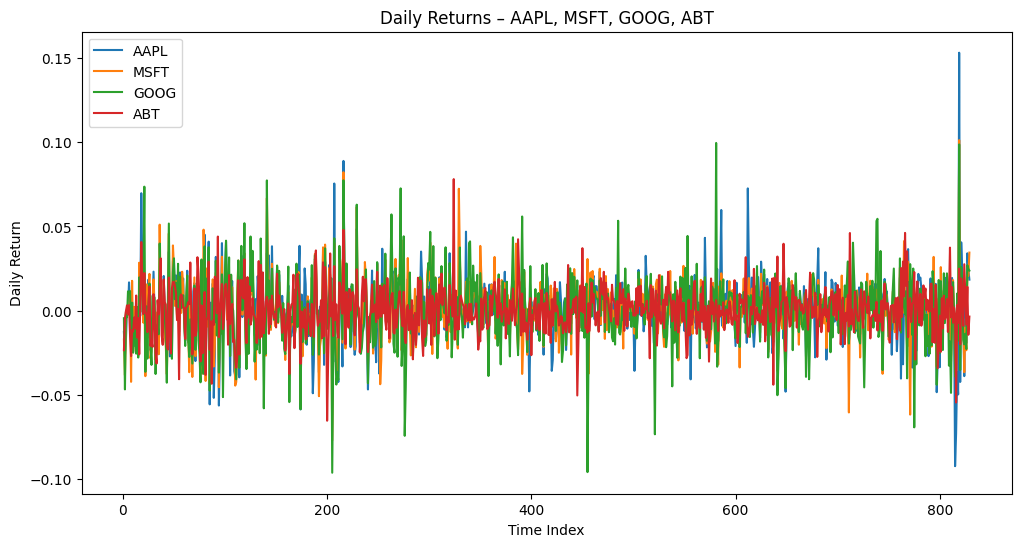

In [12]:
def plot_ticker_returns(tickers):
    # allow a single ticker string as input
    if isinstance(tickers, str):
        tickers = [tickers]
    # select the rows and transpose so time is on the x‐axis
    data = time_series.loc[tickers].T
    data.columns = tickers
    data.plot(figsize=(12, 6))
    plt.xlabel('Time Index')
    plt.ylabel('Daily Return')
    plt.title(f"Daily Returns – {', '.join(tickers)}")
    plt.legend()
    plt.show()

# example usage
plot_ticker_returns(['AAPL', 'MSFT', 'GOOG', 'ABT'])


In [13]:
# Split static_data into separate DataFrames by year and align to time_series.index
for year in static_data['Year'].unique():
    # slice out this year's data
    df = static_data[static_data['Year'] == year].reset_index(drop=True)
    # reindex by ticker to match time_series rows
    df = df.set_index('Ticker').reindex(time_series.index).reset_index().drop(columns=['index', "Year"])

    # MEDIAN IMPUTATION... May change (but we have small amount of missing data )
    if df.isnull().values.any():
        df = df.fillna(df.median(numeric_only=True))

    globals()[f"static{year}"] = df
    #df.to_csv(f"static{year}.csv", index=False)  # Save as CSV
    print(f"static{year} aligned with time_series, shape {df.shape}, saved as static{year}.csv")

static2024 aligned with time_series, shape (503, 11), saved as static2024.csv
static2023 aligned with time_series, shape (503, 11), saved as static2023.csv
static2022 aligned with time_series, shape (503, 11), saved as static2022.csv
static2025 aligned with time_series, shape (503, 11), saved as static2025.csv


In [ ]:
"""#Save the labels and timeseries as dataframes
labels_df = pd.DataFrame(labels, columns=['Labels'])
labels_df.to_csv("labels.csv", index=False)  # Save as CSV
time_series_df = pd.DataFrame(time_series)
time_series_df.to_csv("time_series.csv", index=False)  # Save as CSV"""

# Creating the Proximities

In [15]:
from QGAP.qgap import QGAP
qgap = QGAP(matrix_type="dense")
quant_prox = data_to_proximities(qgap, time_series, labels, None, static2024, None)


In [16]:
qgap._estimator.oob_score_

0.6063618290258449

In [17]:
redcomets = REDCOMETS(variant = 3) #static = XSTATIC
redcomets_prox = data_to_proximities(qgap, time_series, labels, None, static2024, None)

In [18]:
# Rocket
from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket

rf_rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512) # Rocket Kwargs
rocket_prox = data_to_proximities(rf_rocket, time_series, labels, None, static2024 , None)


In [33]:
rf_rocket.rf_gap.oob_score_

0.4711729622266402

In [28]:
# # RDST
from RDST.rdst import RDST_GAP
rdst = RDST_GAP(save_transformed_data = True)
rdst_prox = data_to_proximities(rdst, time_series, labels, None, static2024 , None)

# rdst_prox = np.load("rdst_prox.npy")


In [29]:
rdst._estimator.oob_score_ #Without Static score: 0.5308151093439364

0.5546719681908548

In [21]:
#NOTE: THIS TAKES FOREVER
# sys.path.insert(0, '/yunity/arusty/PF-GAP/PFGAP')
# from PFGAP.PyPFGAP import PyPFGAP
# pf = PyPFGAP()
# pf_prox = data_to_proximities(pf, time_series, labels.astype(str), None, None, None)

# Read in the file that took nearly 1.5 hours to run
pf_prox = np.load("pf_prox.npy")

In [22]:
rocket_prox.shape, redcomets_prox.shape, quant_prox.shape, rdst_prox.shape

((503, 503), (503, 503), (503, 503), (503, 503))

In [30]:
import os

prox_dir = "prox_files"
os.makedirs(prox_dir, exist_ok=True)

np.save(os.path.join(prox_dir, "quant_prox.npy"), quant_prox)
np.save(os.path.join(prox_dir, "redcomets_prox.npy"), redcomets_prox)
np.save(os.path.join(prox_dir, "rocket_prox.npy"), rocket_prox)
np.save(os.path.join(prox_dir, "rdst_prox.npy"), rdst_prox)
#np.save(os.path.join(prox_dir, "pf_prox.npy"), pf_prox)

# Clustering the data

In [25]:
from sklearn.manifold import MDS
# Initialize MDS
def build_mds(prox):
    """
    TODO: Also check the label ordering is being preserved
    1. TODO
    - Try different parametres
    - Normalize (Min/Max) across the each row
    - Still apply the symmetric, and then then 1 - symmetric
    2. Try PHATE
    """
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    symetric = (prox + prox.T) / 2
    mds_prox = mds.fit_transform((1 - symetric)**2)
    return mds_prox

# Build MDS for each method
mds_quant = build_mds(quant_prox)
mds_redcomets = build_mds( redcomets_prox)
mds_rocket = build_mds(rocket_prox)
mds_rdst = build_mds(rdst_prox)
mds_pf = build_mds(pf_prox)


In [26]:
np.unique(labels), len(labels) # NOTE: -1 is for missing values

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8), 503)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 496 but size of corresponding boolean axis is 503

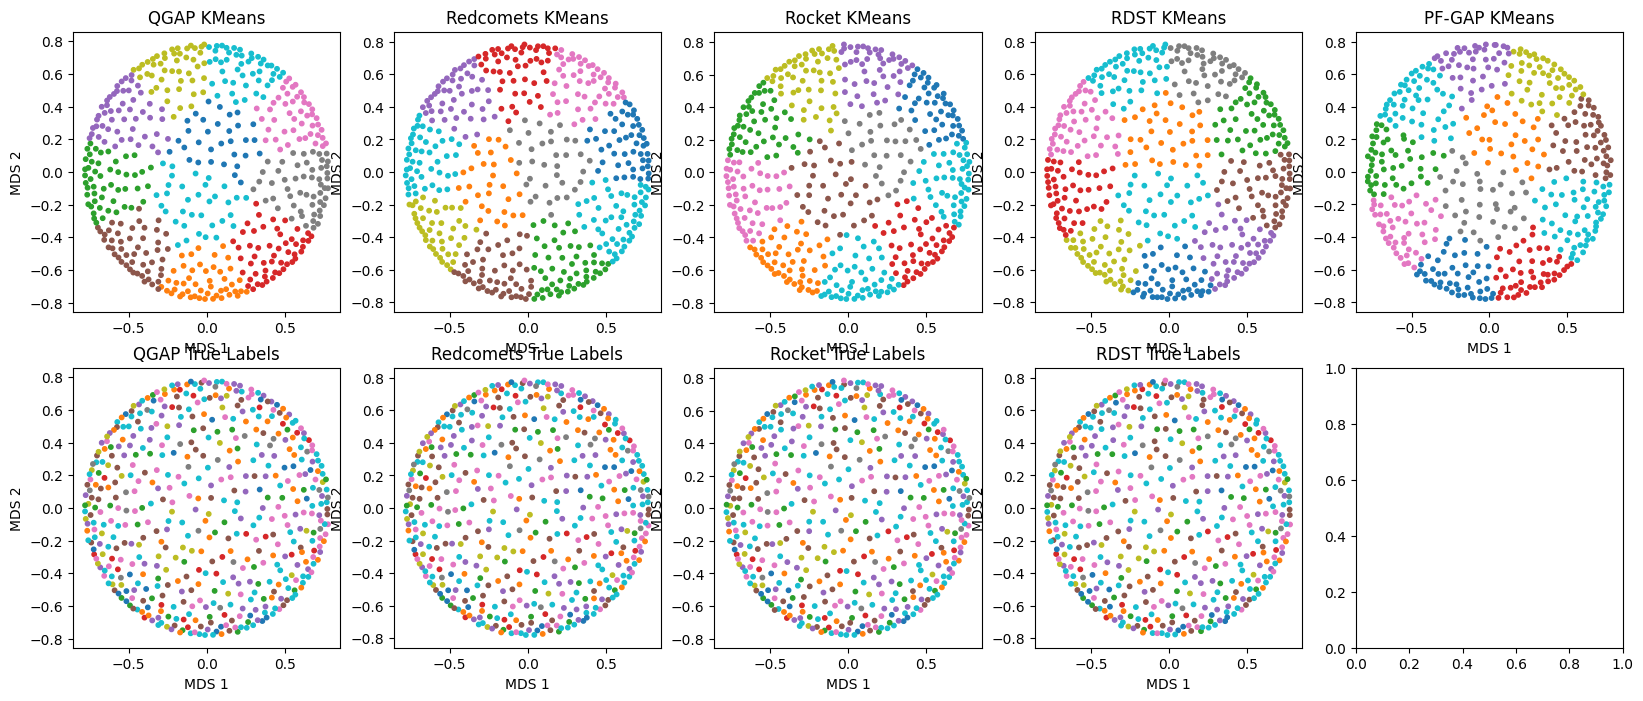

In [27]:
from sklearn.cluster import KMeans

mds_vars = {
    "QGAP": mds_quant,
    "Redcomets": mds_redcomets,
    "Rocket": mds_rocket,
    "RDST": mds_rdst,
    "PF-GAP": mds_pf
}

n_clusters = len(np.unique(labels[labels >= 0]))  # ignore -1 (missing)

fig, axes = plt.subplots(2, len(mds_vars), figsize=(20, 8), gridspec_kw={'height_ratios': [4, 4]})

for col, (name, mds_data) in enumerate(mds_vars.items()):
    # KMeans clustering plot (top row)
    ax = axes[0, col]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(mds_data)
    scatter = ax.scatter(mds_data[:, 0], mds_data[:, 1], c=clusters, cmap='tab10', s=10)
    ax.set_title(f"{name} KMeans")
    ax.set_xlabel("MDS 1")
    ax.set_ylabel("MDS 2")

    # True labels plot (bottom row)
    ax2 = axes[1, col]
    # Only plot points with valid labels
    valid = labels >= 0
    ax2.scatter(mds_data[valid, 0], mds_data[valid, 1], c=labels[valid], cmap='tab10', s=10)
    ax2.set_title(f"{name} True Labels")
    ax2.set_xlabel("MDS 1")
    ax2.set_ylabel("MDS 2")

plt.tight_layout()
plt.show()

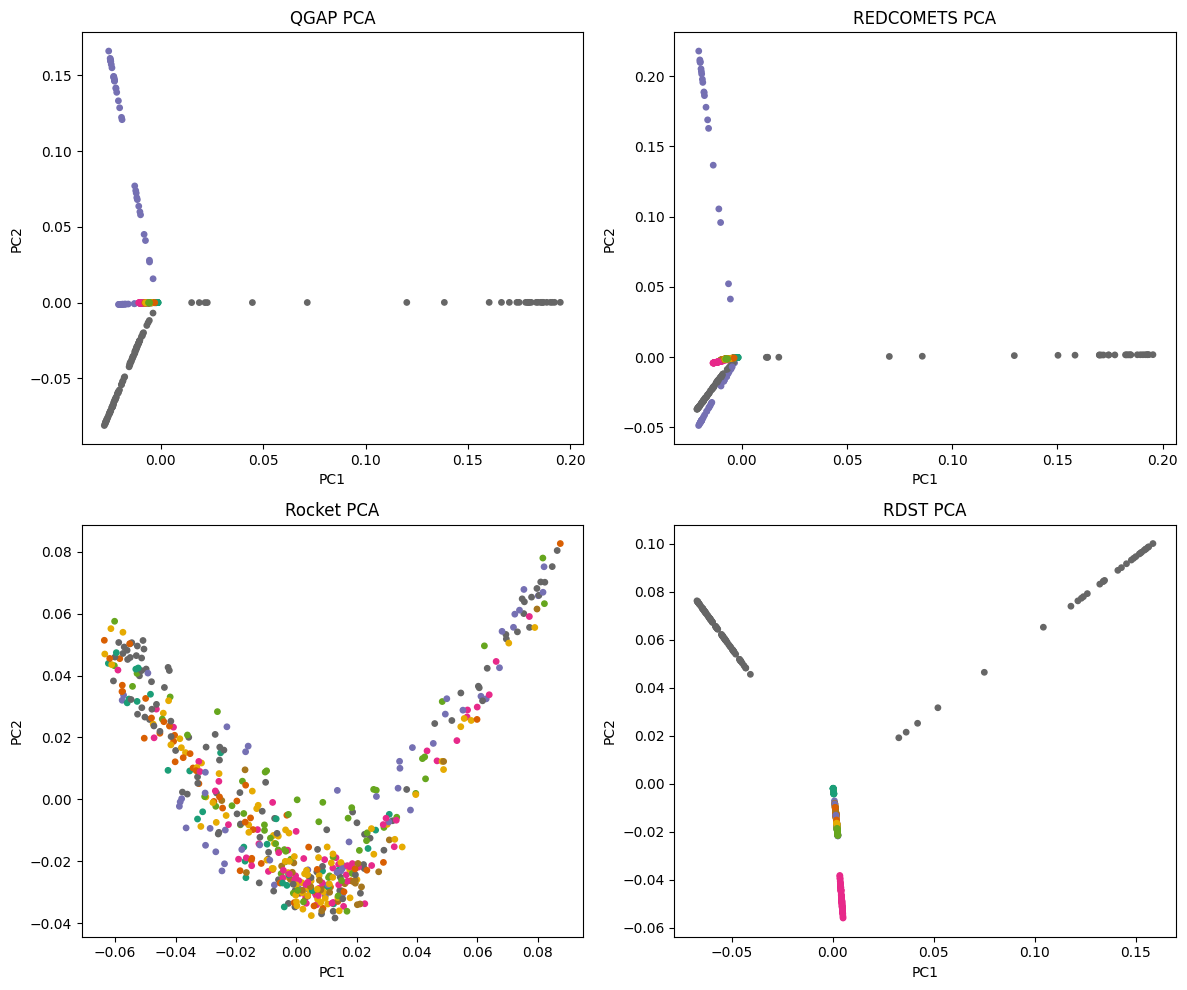

In [ ]:
from sklearn.decomposition import PCA

def plot_pca_in_grid(matrices, titles):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, matrix, title in zip(axes.flat, matrices, titles):
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(matrix)
        ax.scatter(reduced[:, 0], reduced[:, 1], c=labels.astype(int), cmap='Dark2', s=15)
        ax.set_title(title)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
    plt.tight_layout()
    plt.show()

matrices = [quant_prox, redcomets_prox, rocket_prox, rdst_prox]
titles = ["QGAP PCA", "REDCOMETS PCA", "Rocket PCA", "RDST PCA"]

plot_pca_in_grid(matrices, titles)

# K-Fold Accuracy Tests

## Uses all the train data
- Unsure where to use the test data in this example. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Do five tests
n = len(time_series)

# Loop to do random tests
for i in range(6):
    # Use different subsets of the static data for training and testing
    if i < 2:
        static_train = static2022
        static_test = static2023
    elif i < 4:
        static_train = static2023
        static_test = static2024
    else:
        static_train = static2024
        static_test = static2025

    # Randomly select 80% of the data for training
    train_indices = np.random.choice(n, size=int(0.8 * n), replace=False)
    test_indices = np.setdiff1d(np.arange(n), train_indices)

    # Create the training and testing sets
    train_set = time_series.iloc[train_indices]
    test_set = time_series.iloc[test_indices]
    train_labels = labels[train_indices]
    test_labels = labels[test_indices]
    train_static = static_train.iloc[train_indices]
    test_static = static_test.iloc[test_indices]

    ### Test predictive accuracy of the model.... how? ###

    # Create the proximities for the training and testing sets
    quant_prox_train = data_to_proximities(qgap, train_set, train_labels, None, train_static, None)
    #quant_prox_test = data_to_proximities(qgap, test_set, test_labels, None, test_static, None)

    # Train a KNN model on the proximities
    knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    knn.fit(1 - quant_prox_train, train_labels)

    train_score = knn.score(1 -quant_prox_train, train_labels)
    print(f"Fold {i+1}: Train Accuracy = {train_score:.3f}, (Train size: {len(train_indices)})")


Fold 1: Train Accuracy = 1.000, (Train size: 396)
Fold 2: Train Accuracy = 1.000, (Train size: 396)
Fold 3: Train Accuracy = 1.000, (Train size: 396)
Fold 4: Train Accuracy = 1.000, (Train size: 396)
Fold 5: Train Accuracy = 1.000, (Train size: 396)
Fold 6: Train Accuracy = 1.000, (Train size: 396)


## Forms proximites
- then splits the proximities into train and test data

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n = len(time_series)


for i in range(0, 6, 2):
    if i < 2:
        static_train = static2022
        static_test = static2023
    elif i < 4:
        static_train = static2023
        static_test = static2024
    else:
        static_train = static2024
        static_test = static2025

    # Compute proximities for all data at once
    quant_prox_all = data_to_proximities(qgap, time_series, labels, None, static_train, None)


    train_indices = np.random.choice(n, size=int(0.8 * n), replace=False)
    test_indices = np.setdiff1d(np.arange(n), train_indices)

    train_labels = labels[train_indices]
    test_labels = labels[test_indices]

    # Split the proximity matrix
    prox_train = quant_prox_all[np.ix_(train_indices, train_indices)]
    prox_test = quant_prox_all[np.ix_(test_indices, train_indices)]

    knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    knn.fit(1 - prox_train, train_labels)

    train_score = knn.score(1 - prox_train, train_labels)
    test_score = knn.score(1 - prox_test, test_labels)
    print(f"Fold {i+1}: Train Accuracy = {train_score:.3f}, Test Accuracy = {test_score:.3f} (Train size: {len(train_indices)})")


Fold 1: Train Accuracy = 1.000, Test Accuracy = 1.000 (Train size: 396)
Fold 3: Train Accuracy = 1.000, Test Accuracy = 1.000 (Train size: 396)
Fold 5: Train Accuracy = 1.000, Test Accuracy = 1.000 (Train size: 396)


## Third way to test?
- To truly get a fair comparison we may need to use prox_extend

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Do five tests
n = len(time_series)

for i in range(6):
    # Use different subsets of the static data for training and testing
    if i < 2:
        static_train = static2022
        static_test = static2023
    elif i < 4:
        static_train = static2023
        static_test = static2024
    else:
        static_train = static2024
        static_test = static2025

    # Randomly select 80% of the data for training
    train_indices = np.random.choice(n, size=int(0.8 * n), replace=False)
    test_indices = np.setdiff1d(np.arange(n), train_indices)

    train_labels = labels[train_indices]
    test_labels = labels[test_indices]

    # Compute proximities for all data at once
    quant_prox_all = data_to_proximities(qgap, time_series, labels, None, static_train, None)

    # Split the proximity matrix
    prox_train = quant_prox_all[np.ix_(train_indices, train_indices)]
    prox_test = quant_prox_all[np.ix_(test_indices, train_indices)]

    # Train a KNN model on the proximities
    knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    knn.fit(1 - prox_train, train_labels)

    train_score = knn.score(1 - prox_train, train_labels)
    test_score = knn.score(1 - prox_test, test_labels)
    print(f"Fold {i+1}: Train Accuracy = {train_score:.3f}, Test Accuracy = {test_score:.3f} (Train size: {len(train_indices)}, Test size: {len(test_indices)})")


Fold 1: Train Accuracy = 1.000, Test Accuracy = 1.000 (Train size: 396, Test size: 100)
Fold 2: Train Accuracy = 1.000, Test Accuracy = 1.000 (Train size: 396, Test size: 100)
Fold 3: Train Accuracy = 1.000, Test Accuracy = 1.000 (Train size: 396, Test size: 100)
Fold 4: Train Accuracy = 1.000, Test Accuracy = 1.000 (Train size: 396, Test size: 100)
Fold 5: Train Accuracy = 1.000, Test Accuracy = 1.000 (Train size: 396, Test size: 100)
Fold 6: Train Accuracy = 1.000, Test Accuracy = 1.000 (Train size: 396, Test size: 100)


# Determining Feature importance
-> Did the static features turn out important at all?

Time series Features range O to 7456
Static Features range 7456 to 7467


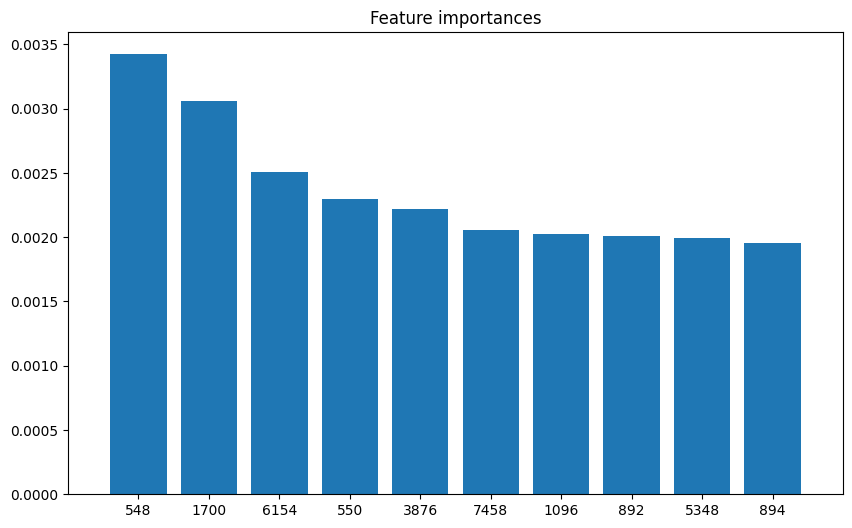

In [ ]:
from QGAP.qgap import QGAP
qgap = QGAP(matrix_type="dense")

qgap.fit(time_series, labels, static = static2024)

# Retrieve feature importances:
importances = qgap._estimator.feature_importances_
# Sort the importances in descending order
indices = np.argsort(importances)[::-1]

print(f"Time series Features range O to {len(importances) - 11}")
print(f"Static Features range {len(importances) - 11} to {len(importances)}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), indices[:10])
plt.xlim([-1, 10])
plt.show()


In [ ]:
static2024.shape, importances.shape

((496, 11), (7467,))

In [ ]:
# Extract and print feature importances for static variables
static_feature_importances = importances[-11:]  # Last 11 features correspond to static variables
static_feature_names = static2024.columns.tolist()

print("Feature Importances for Static Variables:")
for name, importance in zip(static_feature_names, static_feature_importances):
    print(f"{name}: {importance:.4f}")

Feature Importances for Static Variables:
PE Ratio: 0.0003
PB Ratio: 0.0000
PS Ratio: 0.0021
ROE: 0.0000
ROA: 0.0011
Debt/Equity: 0.0002
Current Ratio: 0.0002
Profit Margin: 0.0003
Revenue Growth YoY: 0.0002
EPS Growth Next 5Y: 0.0000
Market Cap: 0.0000


Time series Features range O to 30000
Static Features range 30000 to 30011
Feature Importances for Static Variables:
PE Ratio: 0.0001
PB Ratio: 0.0001
PS Ratio: 0.0007
ROE: 0.0000
ROA: 0.0010
Debt/Equity: 0.0001
Current Ratio: 0.0000
Profit Margin: 0.0001
Revenue Growth YoY: 0.0001
EPS Growth Next 5Y: 0.0000
Market Cap: 0.0000


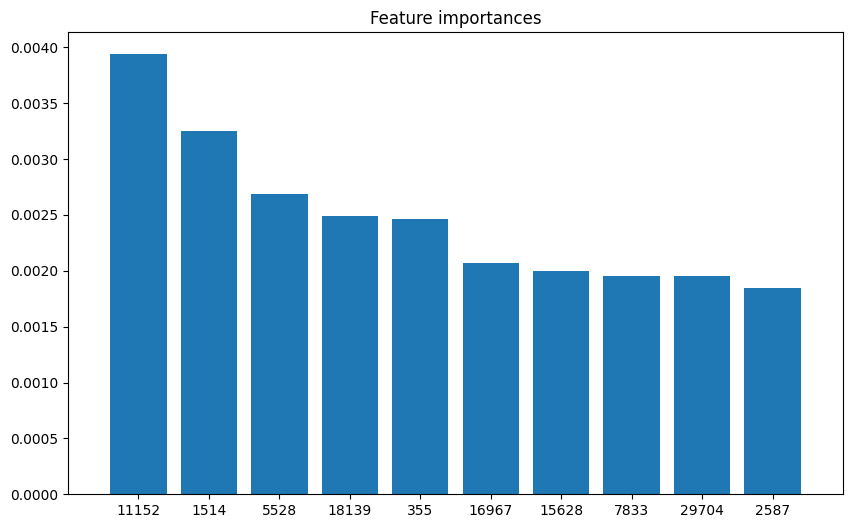

In [ ]:
### RDST Trials and Results ###

from RDST.rdst import RDST_GAP

rdst = RDST_GAP(save_transformed_data = True)

rdst.fit(time_series, labels, static = static2024)

# Retrieve feature importances:
importances = rdst._estimator.feature_importances_
# Sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Extract and print feature importances for static variables
static_feature_importances = importances[-11:]  # Last 11 features correspond to static variables
static_feature_names = static2024.columns.tolist()

print(f"Time series Features range O to {len(importances) - 11}")
print(f"Static Features range {len(importances) - 11} to {len(importances)}")

print("Feature Importances for Static Variables:")
for name, importance in zip(static_feature_names, static_feature_importances):
    print(f"{name}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), indices[:10])
plt.xlim([-1, 10])
plt.show()

Time series Features range O to 4032
Static Features range 4032 to 8058
Feature Importances for Static Variables:
PE Ratio: 0.0000
PB Ratio: 0.0001
PS Ratio: 0.0002
ROE: 0.0001
ROA: 0.0001
Debt/Equity: 0.0001
Current Ratio: 0.0001
Profit Margin: 0.0000
Revenue Growth YoY: 0.0001
EPS Growth Next 5Y: 0.0000
Market Cap: 0.0000


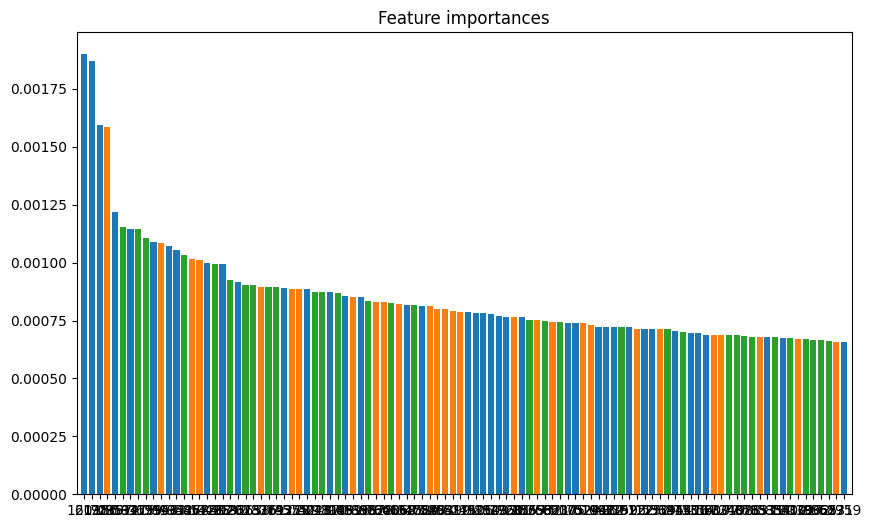

In [ ]:
### ROCKET Trials and Results ###

from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket

rf_rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512)

rf_rocket.fit(time_series, labels, static = static2024, weights = 1) # THIS WEIGHTS STATIC as half important

# Retrieve feature importances:
importances = rf_rocket.rf_gap.feature_importances_
# Sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Extract and print feature importances for static variables
static_feature_importances = importances[-11:]  # Last 11 features correspond to static variables
static_feature_names = static2024.columns.tolist()

print(f"Time series Features range O to 4032")
print(f"Static Features range 4032 to {len(importances)}")

print("Feature Importances for Static Variables:")
for name, importance in zip(static_feature_names, static_feature_importances):
    print(f"{name}: {importance:.4f}")

# Create a color list: blue for time series, orange for static features
bar_colors = ['tab:blue' if idx <= 2016 else 'tab:green' if idx <= 4032 else 'tab:orange' for idx in indices[:100]]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(100), importances[indices[:100]], align="center", color=bar_colors)
plt.xticks(range(100), indices[:100])
plt.xlim([-1, 100])
plt.show()
